### Problem Statement

#### Objectives
As a new hire to the ML Engineering team at CyberProtect, you have been entrusted with a critical task: protecting the users of CyberProtect from phishing attacks when they are assessing websites on the internet.

CyberProtect has collected a database of phishing websites and legitimate websites. CyberProtect’s data engineering team has extracted various features from these websites that may be helpful to your tasks. These features are described below in the “List of Attributes” section.

By leveraging these features, you will develop predictive models that can be installed as an extension and predict if a website is a phishing attack and warn the user before allowing the user to access it.

Specifically, your task is to build and evaluate prediction models, and also identify their respective key features of the dataset that categorise whether the website is a phishing attack. Your analysis should also include evaluation of which features contribute most significantly to phishing attack prediction.

In your submission, you are expected to build and evaluate at least three suitable models for this task and justify your choices based on the dataset provided.

#### Dataset
The dataset contains various features such as number of URL redirects, number of external references , which are gathered by the data engineering team to help your work. Specific information on the various dataset features shall be provided in the next page.

Important Note: The dataset contains synthetic or contaminated data. Therefore, you should state clearly any assumptions or justifications that you make in processing the data, including handling of outliers, missing values, and data quality issues.

You can query the dataset using the following URL:
https://techassessment.blob.core.windows.net/aiap22-assessment-data/phishing.db

#### List of Attributes
| Attribute           | Description                                               |
|---------------------|-----------------------------------------------------------|
| LineOfCode          | Number of lines of code                                  |
| LargestLineLength   | Longest line of code                                     |
| NoOfURLRedirect     | Number of URL redirects from the website                 |
| NoOfSelfRedirect    | Number of self-redirects from the website                |
| NoOfPopup           | Number of pop-ups from the website                       |
| NoOfiFrame          | Number of iFrames from the website                       |
| NoOfImage           | Number of images found in the website                    |
| NoOfSelfRef         | Number of clickable links within the same domain         |
| NoOfExternalRef     | Number of clickable links to external websites           |
| Robots              | Whether the website has a robots.txt                     |
| IsResponsive        | Whether the website adapts appropriately across devices  |
| Industry            | The industry the website belongs to                      |
| DomainAgeMonths     | Months since the domain was created                      |
| HostingProvider     | The hosting provider of the website                      |
| label               | 0 = phishing website, 1 = legitimate website             |

Theres an additional attribute not listed in the PDF: NoOfImages

### Library / Dependencies

In [1]:
# Data handling and graphics
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Analysis and Transformers
from scipy.stats import ttest_ind, ks_2samp, chi2_contingency
#from collections import defaultdict
#from sklearn.preprocessing import OneHotEncoder,  StandardScaler , MinMaxScaler , LabelEncoder
#from sklearn.model_selection import train_test_split
#from sklearn.feature_selection import mutual_info_classif # ,mutual_info_regression
#from sklearn.impute import KNNImputer

### Data Cleaning

#### Data Import

In [2]:
# Import Raw Data
# Connect to DB
conn = sqlite3.connect('data/phishing.db')
# Get list of all tables
table_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(table_query, conn)
# Load all tables into a dictionary of dataframes
dataframes = {}
for table_name in tables['name']:
    df = pd.read_sql(f"SELECT * FROM {table_name}", conn)
    dataframes[table_name] = df
    print(f"Loaded table: {table_name}, shape: {df.shape}")

Loaded table: phishing_data, shape: (10500, 16)


In [3]:
# Querying the table
query = f"SELECT * FROM phishing_data"
df_raw = pd.read_sql_query(query, conn)
conn.close() # Good Practice to close
df_raw.head(10)

,Unnamed: 0,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,Industry,HostingProvider,DomainAgeMonths,label
0,0,NaN,9965,0,0,2,1,48,172,170,1,1,Fashion,DreamHost,98,0
1,1,769.0,9507,0,0,0,4,25,55,78,1,1,Fashion,AWS,31,1
2,2,720.0,2550,0,0,0,2,-31,94,13,0,1,Education,Google Cloud,26,1
3,3,198.0,869,0,0,0,0,0,0,2,0,0,Unknown,DreamHost,2,1
4,4,972.0,2807,0,0,0,2,6,83,51,0,1,Education,GoDaddy,43,1
5,5,247.0,4462,0,0,0,0,3,4,4,0,1,Manufacturing,AWS,8,1
6,6,2.0,80,0,0,0,0,0,0,0,0,0,Unknown,Freehostia,8,0
7,7,452.0,9381,0,0,0,0,2,36,42,1,1,Fashion,Bluehost,42,1
8,8,1018.0,9381,0,0,0,2,20,95,96,1,1,Manufacturing,Google Cloud,30,0
9,9,418.0,120391,0,0,0,3,2,0,2,1,0,eCommerce,DreamHost,2,0


In [4]:
# it is good practice to leave raw data untouched, so make a copy for analysis and revision
df_data = df_raw.copy()

#### Cursory Examination and exploration

In [5]:
# Quick examination of the data
df_data.nunique()

Unnamed: 0           10500
LineOfCode            2875
LargestLineLength     4027
NoOfURLRedirect          2
NoOfSelfRedirect         2
NoOfPopup               26
NoOfiFrame              48
NoOfImage              308
NoOfSelfRef            533
NoOfExternalRef        463
Robots                   2
IsResponsive             2
Industry                11
HostingProvider         13
DomainAgeMonths        121
label                    2
dtype: int64

In [6]:
# Quick examination of null values and dtypes
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         10500 non-null  int64  
 1   LineOfCode         8145 non-null   float64
 2   LargestLineLength  10500 non-null  int64  
 3   NoOfURLRedirect    10500 non-null  int64  
 4   NoOfSelfRedirect   10500 non-null  int64  
 5   NoOfPopup          10500 non-null  int64  
 6   NoOfiFrame         10500 non-null  int64  
 7   NoOfImage          10500 non-null  int64  
 8   NoOfSelfRef        10500 non-null  int64  
 9   NoOfExternalRef    10500 non-null  int64  
 10  Robots             10500 non-null  int64  
 11  IsResponsive       10500 non-null  int64  
 12  Industry           10500 non-null  object 
 13  HostingProvider    10500 non-null  object 
 14  DomainAgeMonths    10500 non-null  int64  
 15  label              10500 non-null  int64  
dtypes: float64(1), int64(1

#### Examining Numerical features

My usual templates fail to visual the features well so im doing it one by one.

##### Examining `LineOfCode`

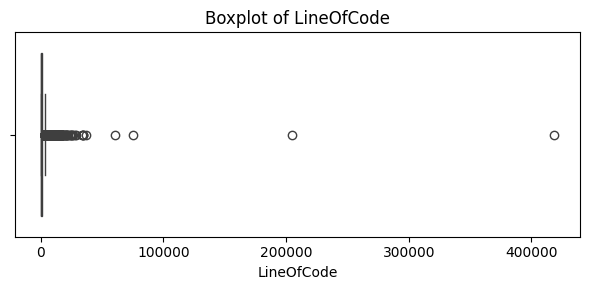

In [7]:
# Displaying a simple plot
plt.figure(figsize=(6, 3))
sns.boxplot(x=df_data['LineOfCode'])
plt.title("Boxplot of LineOfCode")
plt.xlabel("LineOfCode")
plt.tight_layout()
plt.show()

There are severe right tailed outliers.

In [8]:
# Examining the right tail/ Outlier Threshold
df_data['LineOfCode'].describe(percentiles=[0.90, 0.95, 0.98, 0.99])

count      8145.000000
mean       1376.952363
std        5751.557001
min           2.000000
50%         620.000000
90%        3055.200000
95%        4911.200000
98%        8287.920000
99%       11412.880000
max      418650.000000
Name: LineOfCode, dtype: float64

In [9]:
# Examining upper percentiles
q98 = df_data['LineOfCode'].quantile(0.98)
df_outliers = df_data[df_data['LineOfCode'] > q98].copy()
df_outliers.sort_values('LineOfCode', ascending=False, inplace=True)

df_outliers.head(20)

,Unnamed: 0,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,Industry,HostingProvider,DomainAgeMonths,label
10157,10157,418650.0,20750,0,0,0,0,667,485,65,0,1,eCommerce,Unknown Provider,100,1
1583,1583,205162.0,2584,0,0,0,0,284,26596,80,0,1,eCommerce,Azure,32,1
5575,5575,75064.0,1437,0,0,0,0,1906,35,1917,0,0,Non-profit,Unknown Provider,71,1
651,651,61048.0,4612,0,0,6,7,37,4071,4142,0,0,eCommerce,GoDaddy,44,0
6401,6401,37076.0,4812,0,0,10,14,36,11863,11901,0,0,Fashion,AWS,17,1
4695,4695,34778.0,14399,0,0,0,19,199,229,16,0,1,eCommerce,DreamHost,75,1
4364,4364,34444.0,3944,0,0,0,19,2260,519,228,0,1,Healthcare,Hostinger,81,1
7778,7778,34382.0,39008,0,0,0,21,853,319,26,0,1,eCommerce,Unknown Provider,103,1
706,706,33848.0,4379,0,0,564,10,1112,1253,1707,0,1,Non-profit,Bluehost,55,1
6147,6147,28939.0,18733,0,0,0,2,602,2745,2657,0,1,eCommerce,Google Cloud,8,1


The distribution is heavy-tailed, right-skewed, do not winsorize otherwise i will lose potential signal (i cant see it but it would not hurt in this case) or log transform and add a binary flag

##### Examining `LargestLineLength`

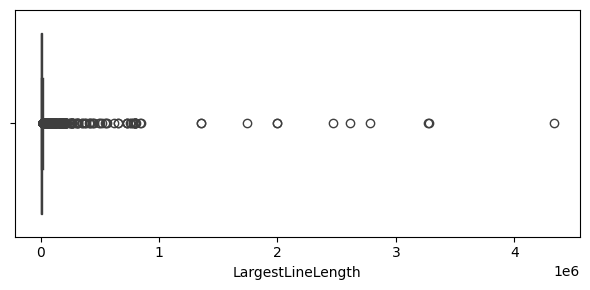

In [10]:
# Displaying a simple plot
plt.figure(figsize=(6, 3))
sns.boxplot(x=df_data['LargestLineLength'])
plt.tight_layout()
plt.show()

In [31]:
# Examining the right tail/ Outlier Threshold
df_data['LargestLineLength'].describe(percentiles=[0.90, 0.95, 0.98, 0.99])

count    1.050000e+04
mean     1.119796e+04
std      9.416898e+04
min      2.200000e+01
50%      1.087500e+03
90%      1.418560e+04
95%      2.649060e+04
98%      5.642142e+04
99%      1.294878e+05
max      4.336498e+06
Name: LargestLineLength, dtype: float64

log transform and binary outlier flag

#### Duplicate data in the set

In [11]:
# Checking Duplciates
df_duplicated = df_data[df_data.duplicated(keep=False)]
df_duplicated.nunique()

Unnamed: 0           0
LineOfCode           0
LargestLineLength    0
NoOfURLRedirect      0
NoOfSelfRedirect     0
NoOfPopup            0
NoOfiFrame           0
NoOfImage            0
NoOfSelfRef          0
NoOfExternalRef      0
Robots               0
IsResponsive         0
Industry             0
HostingProvider      0
DomainAgeMonths      0
label                0
dtype: int64

In [12]:
# Examining missing hosting providers
df_duplicated['HostingProvider'].unique()

array([], dtype=object)

`NoOfURLRedirect`, `NoOfSelfRedirect`, `NoOfPopup` all have the same outputs.  
Azure, Godaddy, AWS, Google Cloud are not amongst the hosts.  
Duplicates in a cybersecurity setting might represent attack signals from a similar source.  
Data cleaning of duplicates will remove this signal.  
Further assessment will be done at or after feature engineering to transform these into signals  

##### Cursory Assessment  
Null values for `LineOfCode`. The dtype should be int instead of float.  
string cleaning might be needed for object dtypes.  
Unamed: 0 appears to be another index and can be dropped.  
There is a attribute not listed in the initial table `NoOfImage`, it as been added post assessment.

#### Dropping ghost-index `Unnamed: 0`

In [13]:
# Checking for unique counts
df_data['Unnamed: 0'].nunique() == len(df_data)

True

In [14]:
# checking for Total value difference
(df_data['Unnamed: 0'] - df_data.index).abs().sum()

np.int64(0)

In [15]:
# dropping the column
df_data = df_data.drop(columns=['Unnamed: 0'])

In [16]:
# Quick Confirmation
df_data.head()

,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,Industry,HostingProvider,DomainAgeMonths,label
0,NaN,9965,0,0,2,1,48,172,170,1,1,Fashion,DreamHost,98,0
1,769.0,9507,0,0,0,4,25,55,78,1,1,Fashion,AWS,31,1
2,720.0,2550,0,0,0,2,-31,94,13,0,1,Education,Google Cloud,26,1
3,198.0,869,0,0,0,0,0,0,2,0,0,Unknown,DreamHost,2,1
4,972.0,2807,0,0,0,2,6,83,51,0,1,Education,GoDaddy,43,1


#### Rename`IsResponsive` to `is_responsive` 

In [17]:
# Renaming to follow schema / naming convention
df_data.rename(columns={"IsResponsive": "is_responsive"}, inplace=True)

#### Rename`Robots` to `has_robotstxt`

In [18]:
# Renaming to make feature name more intuitive
df_data.rename(columns={"Robots": "has_robotstxt"}, inplace=True)

#### Rename `label` to `is_legitimate`

In [19]:
# Renaming to make features's purpose clearer
df_data.rename(columns={"label": "is_legitimate"}, inplace=True)

#### Examining and string cleaning `Industry` and `HostingProvider`

In [20]:
df_data['Industry'].unique()

array(['Fashion', 'Education', 'Unknown', 'Manufacturing', 'eCommerce ',
       'Non-profit', 'Food', 'Government', 'eCommerce', 'Banking',
       'Healthcare'], dtype=object)

There is a duplicate for `eCommerce` and `eCommerce `, a trailing whitespace.  
We can clean it anyway and query the maintainer for the scrapper for answers why there is this discrepancy.  
I will run a chi-square test just to check if there are any meaningful differences  

In [21]:
# Select the two raw groups
mask = df_data['Industry'].isin(['eCommerce', 'eCommerce '])
subset = df_data[mask].copy()

# Contingency table between industry variant and the target label
table = pd.crosstab(subset['Industry'], subset['is_legitimate'])

# Run chi-square test
chi2, p, dof, expected = chi2_contingency(table)

print("Contingency Table:\n", table)
print("\nChi-square p-value:", p)

Contingency Table:
 is_legitimate     0     1
Industry                 
eCommerce      1371  1150
eCommerce       253   191

Chi-square p-value: 0.3356453330634346


Whitespace variants are not significantly different from each other (χ² p = 0.3356), therefore cleaning and merging them is statistically justified.

In [22]:
df_data['HostingProvider'].unique()

array(['DreamHost', 'AWS', 'Google Cloud', 'GoDaddy', 'Freehostia',
       'Bluehost', 'Unknown Provider', 'Hostinger', 'Namecheap',
       'InfinityFree', '000webhost', 'Azure', 'HostGator'], dtype=object)

No discrepancies noted.

In [23]:
# Basic cleaning of strings
for col in df_data.select_dtypes(include=['object', 'string']):
        df_data[col] = (
            df_data[col]
            .str.lower()                            # Converts text to lowercase
            .str.strip()                            # Strip leading/trailing whitespace
            .str.replace(r'\s+', '', regex=True)    # Remove all whitespace (including between words)
            .str.replace('_', '', regex=False)      # Remove all underscores
            .str.replace('.', '', regex=False)      # Remove all periods
        )
# Most of this is unnecessary for this dataset considering we only need to strip trailing whitespace for `eCommerce `
# but we do this in case other datasets would require more robust cleaning to intergrate.

#### Examining `LineOfCode`'s dtype, Converting to `int64`. Examining NaN values

In [24]:
# Checking if there are fractional values (there shouldnt be)
df_fractional = df_data[df_data['LineOfCode'] % 1 != 0].copy()
df_fractional['LineOfCode'].sum()

np.float64(0.0)

In [25]:
# Changing the dtype as its supposed to be semanticly discrete
df_data['LineOfCode'] = df_data['LineOfCode'].astype('Int64')
df_data['LineOfCode'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 10500 entries, 0 to 10499
Series name: LineOfCode
Non-Null Count  Dtype
--------------  -----
8145 non-null   Int64
dtypes: Int64(1)
memory usage: 92.4 KB


In [26]:
# Examining number of NaN Values
df_data['LineOfCode'].isna().sum()

np.int64(2355)

These values constitute 22.4% of the dataset and constitutes a large part of the set. It cannot be dropped. without harm

In [27]:
# Sepearting Nan from Non-Nans to see if theres a distinction
df_nan = df_data[df_data['LineOfCode'].isna()]
df_non = df_data[df_data['LineOfCode'].notna()]

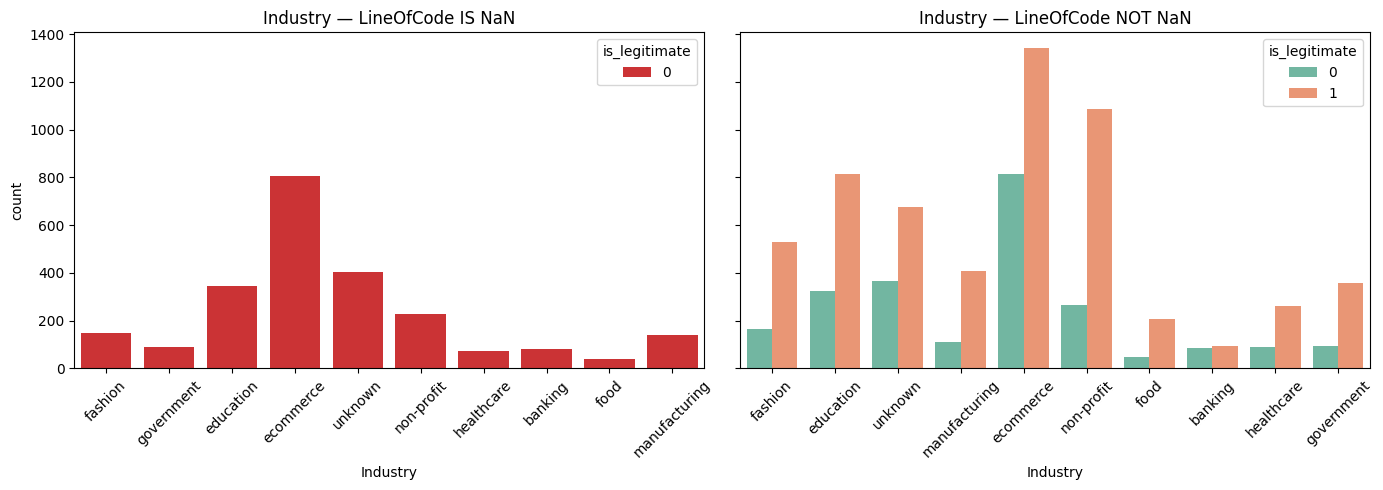

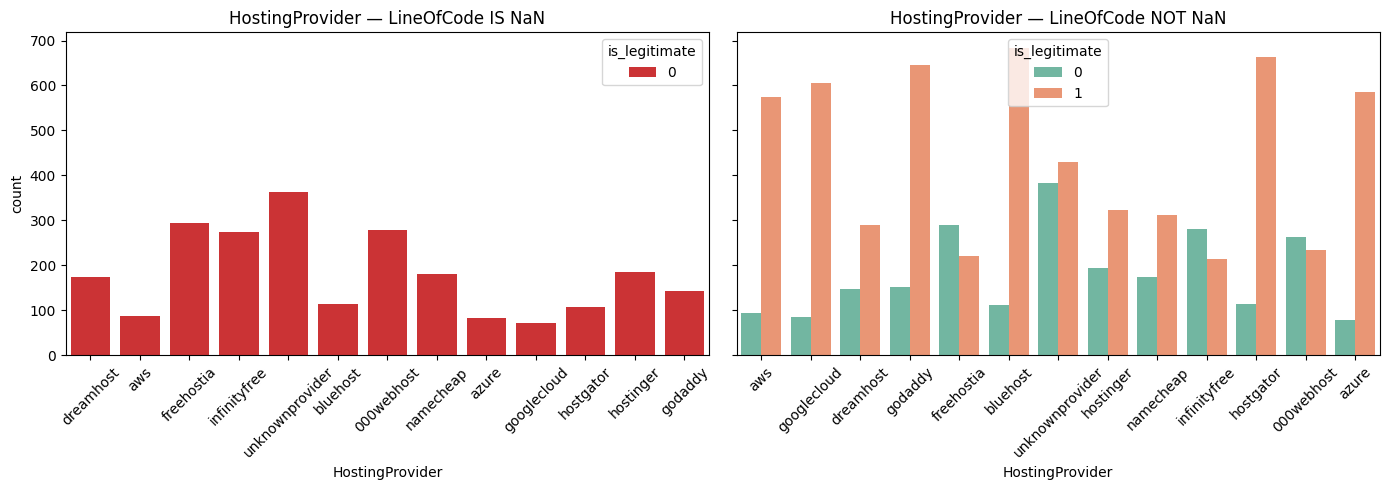

In [28]:
# Plotting both populations against categorical features
cat_features = df_data.select_dtypes(include=['object']).columns.tolist()
cat_features = [c for c in cat_features if c not in ['LineOfCode']]

for col in cat_features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # Left: NaN group
    sns.countplot(
        data=df_nan,
        x=col,
        hue='is_legitimate',
        ax=axes[0],
        palette='Set1'
    )
    axes[0].set_title(f"{col} — LineOfCode IS NaN")
    axes[0].tick_params(axis='x', rotation=45)

    # Right: Non-NaN group
    sns.countplot(
        data=df_non,
        x=col,
        hue='is_legitimate',
        ax=axes[1],
        palette='Set2'
    )
    axes[1].set_title(f"{col} — LineOfCode NOT NaN")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()



In [29]:
# Plotting against numerical features
for col in num_features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    sns.kdeplot(data=df_nan, x=col, hue='is_legitimate', ax=axes[0])
    axes[0].set_title(f"{col} — LineOfCode IS NaN")

    sns.kdeplot(data=df_non, x=col, hue='is_legitimate', ax=axes[1])
    axes[1].set_title(f"{col} — LineOfCode NOT NaN")

    plt.tight_layout()
    plt.show()

NameError: name 'num_features' is not defined

In [ ]:
# Double Checking if all Nan values are phishing sites
df_nan['is_legitimate'].value_counts()

All NaN values belong to phishing sites.  
We cannot clean this as this represents a signal.  

### Domain Research

#### Feature relation to phishing

A rough understanding of the attributes/features will help with effective feature engineering

| Attribute           | Description                                               | Possible Attack Vector / Threat Signal                                   |
|---------------------|-----------------------------------------------------------|---------------------------------------------------------------------------|
| LineOfCode          | Number of lines in the HTML/JS/CSS source                | Very small codebases may indicate *single-page phishing kits*; extremely long minified lines can hide *obfuscated payloads*. |
| LargestLineLength   | Length of the longest line of source                     | Long single-line JS often used for *obfuscation*, *malicious script injection*, or *form hijacking*. |
| NoOfURLRedirect     | Total number of HTTP redirects                           | *Redirect chains* used to hide malicious origins, rotate landing pages, track victims, or evade detection. |
| NoOfSelfRedirect    | Redirects back to same domain                            | Masked redirection surfaces; can support *open redirect setups* or hide spoofed URLs. |
| NoOfPopup           | Count of pop-up windows                                 | Used in *fake alerts*, *support scams*, credential prompts, or pressure-inducing dialogs. |
| NoOfiFrame          | Count of iframe elements                                 | Iframes can host *cloaked phishing pages*, *credential-stealing forms*, or *drive-by scripts*. |
| NoOfImage           | Number of Images found in the website                   | Excessive or stolen brand images; hidden tracking pixels; image-based phishing layouts |
| NoOfSelfRef         | Internal links within same domain                        | Low internal structure suggests *throwaway phishing pages* with no real site architecture. |
| NoOfExternalRef     | Outbound links to other domains                          | Few/no external links may indicate isolation typical of *phishing kits*; unusual external links may hide *malicious third-party scripts*. |
| has_robotstxt            | Presence of `robots.txt`                                 | Lack of robots.txt common in *temporary malicious domains* that avoid SEO and indexing. |
| is_responsive        | Whether layout adapts across devices                     | Broken mobile responsiveness typical of *template-based phishing kits* not optimised for real use. |
| Industry            | Inferred industry of site                                | Attackers often mimic *finance*, *government*, *healthcare* for targeted credential harvesting. |
| DomainAgeMonths     | Age of domain                                            | Very new domains strongly tied to *domain churn*, common in phishing and malware delivery. |
| HostingProvider     | Hosting provider name                                    | Bulletproof or low-reputation hosts associated with *malware hosting* or *phishing kits*. |
| is_legitimate               | Ground truth: 0 = phishing, 1 = legitimate               | — |



#### `has_robotstxt`'s influence on other statistics and `LineOfCode`'s NaN values

The presence of a robot.txt's ability to scrape data is a guideline at most, We do not know if the scraper is respecting the Robots Exclusion Protocol (REP).  
The site's agent can still deny scraping via rate limiting or blocking if it is detected.  
There are no features that indicate this, meaning for every row of data, we do not know if it is a full index.  



### Exploratory Tests

#### Exploring Linear Relationships, Pearson's Correlation

#### Exploring Monotonic Relationships, Spearman's Correlation

#### Exploring Mutual Information 

#### Exploring Distributions

#### Exploring Cardinality

In [ ]:
#### Relationship with 

### Feature Engineering

#### Binarisation of `NoOfURLRedirect` and `NoOfSelfRedirect` to create `HasURLRedirect` and `HasSelfRedirect`

The features `NoOfURLRedirect` and `NoOfSelfRedirect` currently hold exclusively binary values (0 or 1) in the phishing.db dataset, despite their names suggesting a numerical count.  
This discrepancy poses a risk if new datasets are introduced where these counts are greater than 1. 

To mitigate this risk and enhance model performance, we apply Binarization to create two new features.  
This engineering step achieves three primary goals:  

- Captures Non-linearity:
Creates a boolean flag (0 or 1) that explicitly isolates the highly predictive 'presence effect'—the difference between zero (no redirects) and non-zero (at least one redirect)—which is often more significant than the difference between count values (e.g., 1 vs. 2).

- Future-Proofing:
Provides a stable, binary signal for the model that remains distinct from the original count features when their values increase past one in new data.

- Interpretability:
Makes the model easier to interpret by allowing direct measurement of the impact of the simple presence of a redirect event.

In [ ]:
# Create new features
df_data['HasURLRedirect'] = (df_data['NoOfURLRedirect'] > 0).astype(int)
df_data['HasSelfRedirect'] = (df_data['NoOfSelfRedirect'] > 0).astype(int)

#### One-hot encoding `Industries`

In [ ]:
# This is 

#### One-Hot encoding `HostingProvider`

#### Imputing a Sentinel/End-of-Tail/Arbitary number for models that cannot handle NaN values in `LinesOfCode`